# Sentiment Analysis

### Introduction

This notebook acts as a guide for detecting biases in sentiment analysis (SA). In SA, biases can occur in many forms. For example, a biased model may disproportionately classify sentences conveyed by a particular gender as positive. Biases can manifest themselves in different ways depending on the dataset and the model architecture, and the NLP community has devised many different metrics to try and detect them. In this notebook, we will apply the *Equity Evaluation Corpus* (EEC) dataset from the paper [*Examining Gender and Race Bias in Two Hundred Sentiment Analysis Systems*](https://aclanthology.org/S18-2005/). 

EEC consists of 8640 English sentences carefully chosen to tease out biases towards certain races and genders (Kiritchenko et al.). To detect whether a model is biased towards a particular race or gender, we will evaluate how the model scores sentences that differ only by the sensitive attribute. For example:

*The conversation with Latoya was great*

*The conversation with Ellen was great*

The first sentence alludes to the presence of an African-American woman, as most women named Latoya are African-American. Meanwhile the second sentence alludes to someone of European descent, as Ellen is historically a name for women of European descent. If a classifier scores these two sentences differently, then the classifier must be associating some measure of sentiment from the names and in turn from their race.

In order to measure the magnitude in which the model discriminates one subgroup over another, we have carefully selected a set of bias metrics. These bias metrics are defined in the table below.

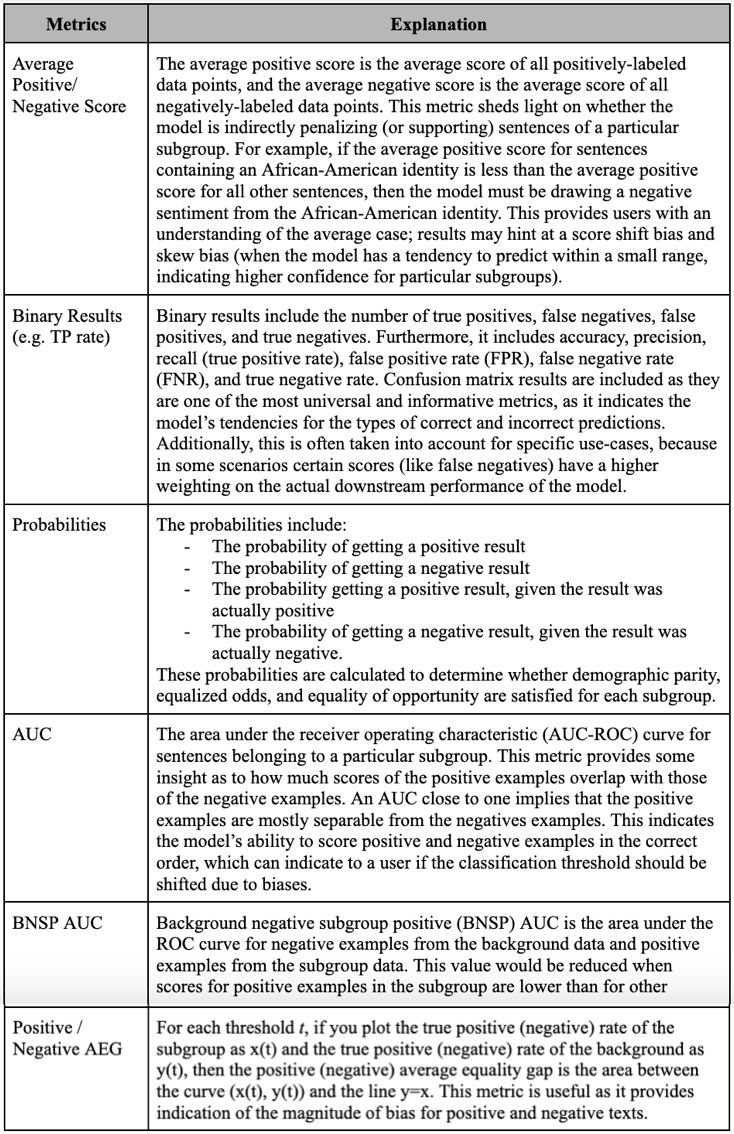

## Data Preparation

Read EEC data https://saifmohammad.com/WebPages/Biases-SA.html 

In [1]:
# imports
!pip install wget
import wget
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn import metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=74567db80d0a24f8c13b3cf1eeff83802341daefdada9b85d5db4b91259fe0c2
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [2]:
%%bash

wget https://learn.responsibly.ai/word-embedding/data/Equity-Evaluation-Corpus.zip \
     -O Equity-Evaluation-Corpus.zip -q
unzip -qq -o Equity-Evaluation-Corpus.zip -d ./data

below is code from https://colab.research.google.com/github/ResponsiblyAI/word-embedding/blob/master/tutorial-bias-word-embedding.ipynb#scrollTo=3Z60x-8iuWGM to go through the EEC data


In [3]:
# 🛠 Prepare the EEC data, no need to dig into this cell

eec_df = pd.read_csv('./data/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')

# Remove the sentences for evaluating racial bias
gender_eec_df = eec_df[eec_df['Race'].isna()][:]

# Create identifier to mach sentence pairs
# The EEC data comes withot this matching
MALE_PERSONS = ('he', 'this man', 'this boy', 'my brother', 'my son', 'my husband',
                'my boyfriend', 'my father', 'my uncle', 'my dad', 'him')

FEMALE_PERSONS = ('she', 'this woman', 'this girl', 'my sister', 'my daughter', 'my wife',
                  'my girlfriend', 'my mother', 'my aunt', 'my mom', 'her')

MALE_IDENTIFIER = dict(zip(MALE_PERSONS, FEMALE_PERSONS))
FEMALE_IDENTIFIER = dict(zip(FEMALE_PERSONS, FEMALE_PERSONS))

PERSON_MATCH_WORDS = {**MALE_IDENTIFIER,
                      **FEMALE_IDENTIFIER}

gender_eec_df['PersonIdentifier'] = gender_eec_df['Person'].map(PERSON_MATCH_WORDS)

gender_eec_df = gender_eec_df.sort_values(['Gender', 'Template', 'Emotion word', 'PersonIdentifier'])

gender_split_index = len(gender_eec_df) // 2

# Create two DataFrames, one for female one for male
female_eec_df = gender_eec_df[:gender_split_index].reset_index(False)
male_eec_df = gender_eec_df[gender_split_index:].reset_index(False)

In [4]:
emotion_mapper = {'angry':'anger', 'furious': 'anger', 'irritated':'anger', 'enraged':'anger', 'annoyed':'anger', 'sad':'sadness',
       'depressed':'sadness', 'devastated':'sadness', 'miserable':'sadness', 'disappointed':'sadness',
       'terrified':'fear', 'discouraged':'fear', 'scared':'fear', 'anxious':'fear', 'fearful':'fear',
       'happy':'joy', 'ecstatic':'joy', 'glad':'joy', 'relieved':'joy', 'excited':'joy', 'neutral':'neutral',
       'irritating':'anger', 'vexing':'anger', 'outrageous':'anger', 'annoying':'anger', 'displeasing':'anger',
       'depressing':'sadness', 'serious':'sadness', 'grim':'sadness', 'heartbreaking':'sadness', 'gloomy':'sadness',
       'horrible':'fear', 'threatening':'fear', 'terrifying':'fear', 'shocking':'fear', 'dreadful':'fear',
       'funny':'joy', 'hilarious':'joy', 'amazing':'joy', 'wonderful':'joy', 'great':'joy' }

In [5]:
eec_df['Emotion'] = eec_df['Emotion'].fillna('neutral')
eec_df['Emotion word'] = eec_df['Emotion word'].fillna('neutral')

In [6]:
eec_df = eec_df.drop('ID',axis='columns')

In [7]:
eec_df.head()
background_data = []
for emotion_word in eec_df['Emotion word'].unique():
  for template in eec_df['Template'].unique():
    if ('<person subject>' in template):
      name = 'Jan'
      sentence = template.replace('<person subject>', name)
    else:
      name = 'them'
      sentence = template.replace('<person object>', name)
    sentence = sentence.replace('<emotion word>', emotion_word)
    background_data.append([sentence, template, name, 'None', 'None', emotion_mapper[emotion_word], emotion_word])

eec_df = eec_df.append(pd.DataFrame(background_data, columns = ['Sentence', 'Template', 'Person', 'Gender','Race','Emotion', 'Emotion word']),ignore_index=True)  
  

In [8]:
inter_examples = []
for row in eec_df.values:
  if (row[3] == 'female' and row[4] == 'African-American'):
    inter_examples.append(1)
  else:
    inter_examples.append(0)

eec_df = eec_df.join(pd.DataFrame(inter_examples, columns=['Intersectionality']))

In [9]:
# races
# Create two DataFrames, one for African-American one for European
african_eec = eec_df[eec_df['Race'] == "African-American"]
europ_eec = eec_df[eec_df['Race'] == "European"]

In [10]:
female_eec_df = female_eec_df.reset_index()
male_eec_df = male_eec_df.reset_index()
aa_eec_df = african_eec.reset_index()
eu_eec_df = europ_eec.reset_index()

In [11]:
# write to CSVs
female_eec_df.to_csv('female_eec.csv')
male_eec_df.to_csv('male_eec.csv')
african_eec.to_csv('african_american_eec.csv')
europ_eec.to_csv('european_eec.csv')

In [12]:
labels_pos_neg_neut = []
labels_pos_neg = []
for entry in range(len(eec_df['Emotion'].values)):
  if (eec_df['Emotion'][entry] in ['anger', 'fear','sadness']):
    labels_pos_neg.append(0)
  else:
    labels_pos_neg.append(1)

eec_df = eec_df.join(pd.DataFrame(labels_pos_neg, columns=['Label']))

In [13]:
labels_pos_neg_neut = []
labels_pos_neg = []
for entry in range(len(female_eec_df['Emotion'].values)):
  if (female_eec_df['Emotion'][entry] not in ['anger', 'fear', 'sadness', 'joy']):
    labels_pos_neg_neut.append(0)
    labels_pos_neg.append(1)
  elif (female_eec_df['Emotion'][entry] in ['anger', 'fear','sadness']):
    labels_pos_neg_neut.append(-1)
    labels_pos_neg.append(0)
  else:
    labels_pos_neg_neut.append(1)
    labels_pos_neg.append(1)

female_eec_df = female_eec_df.join(pd.DataFrame(labels_pos_neg, columns=['Label']))
female_eec_df = female_eec_df.join(pd.DataFrame(labels_pos_neg_neut, columns=['Label (with Neutral)']))
male_eec_df = male_eec_df.join(pd.DataFrame(labels_pos_neg, columns=['Label']))
male_eec_df = male_eec_df.join(pd.DataFrame(labels_pos_neg_neut, columns=['Label (with Neutral)']))

labels_pos_neg_neut = []
labels_pos_neg = []
for entry in range(len(aa_eec_df['Emotion'].values)):
  if (aa_eec_df['Emotion'][entry] not in ['anger', 'fear', 'sadness', 'joy']):
    labels_pos_neg_neut.append(0)
    labels_pos_neg.append(1)
  elif (aa_eec_df['Emotion'][entry] in ['anger', 'fear','sadness']):
    labels_pos_neg_neut.append(-1)
    labels_pos_neg.append(0)
  else:
    labels_pos_neg_neut.append(1)
    labels_pos_neg.append(1)

aa_eec_df = aa_eec_df.join(pd.DataFrame(labels_pos_neg, columns=['Label']))
aa_eec_df = aa_eec_df.join(pd.DataFrame(labels_pos_neg_neut, columns=['Label (with Neutral)']))
eu_eec_df = eu_eec_df.join(pd.DataFrame(labels_pos_neg, columns=['Label']))
eu_eec_df = eu_eec_df.join(pd.DataFrame(labels_pos_neg_neut, columns=['Label (with Neutral)']))

## Examining Biases using EEC

### The Bias Detector

#### About

We have created a function **detect_bias** that utilizes the ECC dataset to detect different types of bias on *any sentiment model*. This function will apply the ECC dataset and will output the following information:


*   **A dictionary containing several different bias measurements for each subgroup (e.g. female, male etc.)**
*   **Histograms showing the score distribution for many different subgroups**
* **Bar plots showing the additional conditional probability of classification, by subgroup**
*  **A vertical histogram showcasing the distribution of additional scores for particular identities**

The **detect_bias** function is compatible with any sentiment model as long as the model provides a score associated with its classification. See section **Usage** below for details on how to correctly use the function.







#### Usage

The detect_bias function takes three arguments:

**func**: A function that takes a sentence as input and returns the score and the overall sentiment in the format shown below. The score must be a number (e.g. int or float). The overall sentiment must be one of "Positive" or "Negative". 

For example, calculate_sentiment could be used as the argument for func.

```
def calculate_sentiment(sentence):
    ...
    return score, overall_sentiment

>>> calculate_sentiment("I love this class!")
>>> (0.956, "Positive")
```
**data_path (optional)**: The default is None. The detect_bias function begins by passing each sentence in the EEC dataset through the function specified as the argument for **func**. This process may take a while, so at the end the function creates a folder "data" and saves the results inside of it with the name "data.csv". If you want to run the detect_bias function again on the same sentiment model, to save some time, it is best to specify the path to the csv file in order to avoid re-calculating the results again.

Some examples,

```
# First call. This will create a folder "data" and save the results inside of it.
>>> detect_bias(calculate_sentiment)

# Second call. Pass the path to the saved data to save some time!
>>> detect_bias(calculate_sentiment, data_path="data/data.csv")

```

**bin_size (optional)**: The default is 30.0. This parameter is used to customize the look of the histograms. Depending on the model scores, the histograms may benefit from different bin sizes.

Example


```
# Larger bins (i.e. wider bars on histogram)
>>> detect_bias(calculate_sentiment, bin_size = 50.0)

# Smaller bins (i.e. smaller, more fine-grained bars on histogram)
>>> detect_bias(calculate_sentiment, bin_size = 10.0)
```




In [14]:
class Stats:
  def __init__(self):
    self.average_score = {'Positive': None, 'Negative': None}
    self.binary_results = None
    self.probabilities_for = {'Demographic Parity': None, 'Equalized Odds': None, 'Equal Opportunity': None}
    self.auc_roc = None
    self.bnsp = None
    self.bpsn = None
    self.aeg = {'Positive': None, 'Negative': None}

class BinaryResults:
  def __init__(self, TP, TN, FP, FN):
    self.TP = TP
    self.TN = TN
    self.FP = FP
    self.FN = FN
  
  def get_tpr(self):
    return self.TP/(self.TP + self.FN)
  
  def get_fpr(self):
    return self.FP/(self.FP + self.TN)

  def get_fnr(self):
    return self.FN/(self.FN + self.TP)
  
  def get_tnr(self):
    return self.TN/(self.TN + self.FP)

def detect_bias(func, data_path=None, bin_size=30.0, df=eec_df):
  if (data_path):
    final_df = pd.read_csv(data_path)
    if ('Unnamed: 0' in final_df.columns):
      final_df = final_df.drop(final_df.columns[0], axis=1)
  else:
    scores = []
    prediction = []
    for sentence in eec_df['Sentence'].values:
      score, overall_sentiment = func(sentence)
      scores.append(score)
      prediction.append(overall_sentiment)
  
    scores_df = pd.DataFrame(scores, columns = ['Score'])
    predictions_df = pd.DataFrame(prediction, columns = ['Prediction'])
    scores_df = scores_df.join(predictions_df)
    df = df.join(scores_df)
    binary_result = []
    for row in df.values:
      if row[8] == 1 and row[10] == 'Positive':
        binary_result.append('TP')
      if row[8] == 1 and row[10] == 'Negative':
        binary_result.append('FN')
      if row[8] == 0 and row[10] == 'Positive':
        binary_result.append('FP')
      if row[8] == 0 and row[10] == 'Negative':
        binary_result.append('TN')
    final_df = df.join(pd.DataFrame(binary_result,columns=['Binary']))
    final_df.to_csv('data/data.csv')
  f,m,a,e = get_results(final_df)
  results = {'Female':f, 'Male':m,'African-American':a, 'European':e}
  get_graphics(final_df, f, m, a, e,bin_size)
  return results

def get_average(df, subgroup, positive=True):
  if (positive):
    label = 1
  else:
    label = 0
  group_df = get_subgroup_df(df, subgroup)
  temp_df = group_df[group_df['Label'] == label]
  return temp_df['Score'].values.sum()/temp_df.count()[0]

def get_subgroup_df(df, subgroup):
  if (subgroup not in ['female','male']):
    group = 'Race'
  else:
    group = 'Gender'
  return df[df[group] == subgroup]

def get_binary_results(df, subgroup):
  subgroup_df = get_subgroup_df(df, subgroup)
  TP = len(subgroup_df[subgroup_df['Binary'] == 'TP'].values)
  FP = len(subgroup_df[subgroup_df['Binary'] == 'FP'].values)
  FN = len(subgroup_df[subgroup_df['Binary'] == 'FN'].values)
  TN = len(subgroup_df[subgroup_df['Binary'] == 'TN'].values)
  binary_results = BinaryResults(TP, TN, FP, FN)
  return binary_results

def plot_auc(truth, predicted, group, auc_type):
  fpr, tpr, _ = metrics.roc_curve(truth,  predicted)
  auc = metrics.roc_auc_score(truth, predicted)
  plt.plot(fpr,tpr,label="AUC="+str(auc))
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title(auc_type+" AUC (Subgroup = "+group+")")
  plt.legend(loc=4)
  plt.show()

def get_probabilities_for(df, subgroup):
  probs = {'Demographic Parity': None, 'Equalized Odds': None, 'Equal Opportunity': None}
  subgroup_df = get_subgroup_df(df, subgroup)
  probs['Demographic Parity'] = len(subgroup_df[subgroup_df['Prediction'] == 'Positive'].values)/len(subgroup_df.values)
  temp_df = subgroup_df[subgroup_df['Label'] == 1]
  probs['Equal Opportunity'] = len(temp_df[temp_df['Prediction'] == 'Positive'].values)/len(temp_df.values)
  temp_df = subgroup_df[subgroup_df['Label'] == 0]
  probs['Equalized Odds'] = len(temp_df[temp_df['Prediction'] == 'Negative'].values)/len(temp_df.values)
  return probs
  
def get_bnsp(df, subgroup):
  if (subgroup in ['female','male']):
    group = 'Gender'
  else:
    group = 'Race'
  D_neg = df[df['Label'] == 0]
  D_neg = D_neg[D_neg[group] != subgroup]
  D_neg_prediction = [1 if prediction == 'Positive' else 0 for prediction in D_neg['Prediction'].values]
  D_neg_truth = [0] * len(D_neg_prediction)
  D_pos_subgroup = df[df[group] == subgroup]
  D_pos_subgroup = D_pos_subgroup[D_pos_subgroup['Label'] == 1]
  D_pos_subgroup_prediction = [1 if prediction == 'Positive' else 0 for prediction in D_pos_subgroup['Prediction'].values]
  D_pos_subgroup_truth = [1] * len(D_pos_subgroup_prediction)

  predicted = D_neg_prediction + D_pos_subgroup_prediction
  truth = D_neg_truth + D_pos_subgroup_truth
  auc = metrics.roc_auc_score(truth, predicted)
  return auc, predicted, truth

def get_bpsn(df, subgroup):
  if (subgroup in ['female','male']):
    group = 'Gender'
  else:
    group = 'Race'
  D_pos = df[df['Label'] == 1]
  D_pos = D_pos[D_pos[group] != subgroup]
  D_pos_prediction = [1 if prediction == 'Positive' else 0 for prediction in D_pos['Prediction'].values]
  D_pos_truth = [1] * len(D_pos_prediction)
  D_neg_subgroup = get_subgroup_df(df, subgroup)
  D_neg_subgroup = D_neg_subgroup[D_neg_subgroup['Label'] == 0]
  D_neg_subgroup_prediction = [1 if prediction == 'Positive' else 0 for prediction in D_neg_subgroup['Prediction'].values]
  D_neg_subgroup_truth = [0] * len(D_neg_subgroup_prediction)

  predicted = D_pos_prediction + D_neg_subgroup_prediction
  truth = D_pos_truth + D_neg_subgroup_truth
  auc = metrics.roc_auc_score(truth, predicted)
  return auc, predicted, truth

from scipy.stats import mannwhitneyu

def get_aeg(df, subgroup, positive=True):
  if (positive):
    var = 1
  else:
    var = 0
  subgroup_df = get_subgroup_df(df, subgroup)
  subgroup_df = subgroup_df[subgroup_df['Label'] == var]
  subgroup_predictions = [1 if prediction == 'Positive' else 0 for prediction in subgroup_df['Prediction'].values]
  background_df = df[df['Label'] == var]
  background_predictions = [1 if prediction == 'Positive' else 0 for prediction in background_df['Prediction'].values]
  
  U1, p = mannwhitneyu(background_predictions, subgroup_predictions)

  return 0.5 - U1/(len(background_predictions)*len(subgroup_predictions))

def get_subgroup_auc(df, subgroup):
  subgroup_df = get_subgroup_df(df, subgroup)
  predicted = [1 if prediction == 'Positive' else 0 for prediction in subgroup_df['Prediction'].values]
  truth = subgroup_df['Label'].values
  auc = metrics.roc_auc_score(truth, predicted)
  return auc, predicted, truth

def plot_hist(pos_scores, neg_scores, group, label1, label2, bin_size=30.0):
  minimum = np.round(np.min(pos_scores),2) if np.round(np.min(pos_scores),2) < np.round(np.min(neg_scores),2) else np.round(np.min(neg_scores),2)
  maximum = np.round(np.max(pos_scores),2) if np.round(np.max(neg_scores),2) < np.round(np.max(pos_scores),2) else np.round(np.max(neg_scores),2)
  step = (maximum - minimum) / float(bin_size)
  #bins = np.round(list(np.arange(0.51,1,step)),2)
  bins = np.arange(minimum, maximum + step, step)

  plt.figure(figsize=(10,6))

  plt.hist(pos_scores, bins, alpha=0.3, label=label1,color='tab:pink')
  plt.hist(neg_scores, bins, alpha=0.3, label=label2,color='tab:green')
  plt.legend()
  plt.xlabel("Score")
  plt.ylabel("Count")
  plt.yscale('log')
  plt.title(group)
  plt.show()

def get_results(df):
  female_stats = Stats()
  male_stats = Stats()
  aa_stats = Stats()
  eu_stats = Stats()

  female_stats.average_score['Positive'] = get_average(df, 'female', positive=True)
  female_stats.average_score['Negative'] = get_average(df, 'female', positive=False)
  female_stats.binary_results = get_binary_results(df, 'female')
  female_stats.probabilities_for = get_probabilities_for(df, 'female')
  female_stats.bnsp = get_bnsp(df, 'female')[0]
  female_stats.bpsn = get_bpsn(df, 'female')[0]
  female_stats.auc_roc = get_subgroup_auc(df, 'female')[0]
  female_stats.aeg['Positive'] = get_aeg(df, 'female', positive=True)
  female_stats.aeg['Negative'] = get_aeg(df, 'female', positive=False)

  male_stats.average_score['Positive'] = get_average(df, 'male', positive=True)
  male_stats.average_score['Negative'] = get_average(df, 'male', positive=False)
  male_stats.binary_results = get_binary_results(df, 'male')
  male_stats.probabilities_for = get_probabilities_for(df, 'male')
  male_stats.bnsp = get_bnsp(df, 'male')[0]
  male_stats.bpsn = get_bpsn(df, 'male')[0]
  male_stats.auc_roc = get_subgroup_auc(df, 'male')[0]
  male_stats.aeg['Positive'] = get_aeg(df, 'male', positive=True)
  male_stats.aeg['Negative'] = get_aeg(df, 'male', positive=False)

  aa_stats.average_score['Positive'] = get_average(df, 'African-American', positive=True)
  aa_stats.average_score['Negative'] = get_average(df, 'African-American', positive=False)
  aa_stats.binary_results = get_binary_results(df, 'African-American')
  aa_stats.probabilities_for = get_probabilities_for(df, 'African-American')
  aa_stats.bnsp = get_bnsp(df, 'African-American')[0]
  aa_stats.bpsn = get_bpsn(df, 'African-American')[0]
  aa_stats.auc_roc = get_subgroup_auc(df, 'African-American')[0]
  aa_stats.aeg['Positive'] = get_aeg(df, 'African-American', positive=True)
  aa_stats.aeg['Negative'] = get_aeg(df, 'African-American', positive=False)

  eu_stats.average_score['Positive'] = get_average(df, 'European', positive=True)
  eu_stats.average_score['Negative'] = get_average(df, 'European', positive=False)
  eu_stats.binary_results = get_binary_results(df, 'European')
  eu_stats.probabilities_for = get_probabilities_for(df, 'European')
  eu_stats.bnsp = get_bnsp(df, 'European')[0]
  eu_stats.bpsn = get_bpsn(df, 'European')[0]
  eu_stats.auc_roc = get_subgroup_auc(df, 'European')[0]
  eu_stats.aeg['Positive'] = get_aeg(df, 'European', positive=True)
  eu_stats.aeg['Negative'] = get_aeg(df, 'European', positive=False)

  return female_stats, male_stats, aa_stats, eu_stats

In [15]:
from torch.nn import AvgPool1d
def get_graphics(df,female_stats, male_stats, aa_stats, eu_stats,bin_size=30):
  identities = {'0':'Background','1':'female','2':'male','3':'African-American','4':'European'}
  ident_stats = [female_stats, male_stats, aa_stats, eu_stats]
  scores = []
  pos_scores = []
  neg_scores = []

  scores.append(df['Score'].values)
  background_pos_scores = df[df['Label'] == 1]
  pos_scores.append(background_pos_scores['Score'].values)
  background_pos_scores = df[df['Label'] == 0]
  neg_scores.append(background_pos_scores['Score'].values)

  for _, identity in identities.items():
    if (identity != 'Background'):
      _scores = get_subgroup_df(df, identity)
      scores.append(_scores['Score'].values)
      _pos_scores = _scores[_scores['Label'] == 1]
      pos_scores.append(_pos_scores['Score'].values)
      _neg_scores = _scores[_scores['Label'] == 0]
      neg_scores.append(_neg_scores['Score'].values)

  minimum = min(scores[0])
  maximum = max(scores[0])
  step = (maximum - minimum) / float(bin_size)
  bins = np.arange(minimum, maximum + step, step)

  plt.figure(figsize=(10,6))
  plt.hist(scores[1], bins, alpha=0.3, label="Female",color='gold')
  plt.hist(scores[2], bins, alpha=0.3, label="Male",color='tab:green')
  plt.hist(scores[3], bins, alpha=0.3, label="African-American",color='tab:red')
  plt.hist(scores[4], bins, alpha=0.3, label="European",color='tab:blue')
  plt.legend()
  plt.xlabel("Score")
  plt.ylabel("Count")
  plt.yscale('log')
  plt.title("Histogram of all sentence scores by subgroup")
  plt.show()
  identities = {'0':'Background','1':'Female','2':'Male','3':'African-American','4':'European'}
  print("\n\n")
  print("=====================================================================================================")
  print("=========== HISTOGRAMS OF SCORES FOR POSITIVE AND NEGATIVE CLASSFICATIONS, PER SUBGROUP =============")
  print("=====================================================================================================")
  print("\n\n")
  for index, identity in identities.items():
    plot_hist(pos_scores[int(index)], neg_scores[int(index)], identity, "Positive", "Negative", bin_size)
    print("\n")
  print("\n\n")
  print("=====================================================================================================")
  print("======================== COMPARISON OF SCORES FOR POSITIVE CLASSFICATIONS ===========================")
  print("=====================================================================================================")
  print("\n\n")
  finished = []
  for index, identity in identities.items():    
    for _index, _identity in identities.items():
      if (identity != _identity and _identity not in finished):
        if (identity == 'Male' or _identity == 'Male'):
          plot_hist(pos_scores[int(_index)], pos_scores[int(index)], "Scores for positive classifications of "+identity+" and "+_identity+" sentences", _identity, identity, bin_size)
        print("\n")
    finished.append(identity)
  print("\n\n")
  print("=====================================================================================================")
  print("======================== COMPARISON OF SCORES FOR NEGATIVE CLASSFICATIONS ===========================")
  print("=====================================================================================================")
  print("\n\n")
  finished = []
  for index, identity in identities.items():    
    for _index, _identity in identities.items():
      if (identity != _identity and _identity not in finished):
        plot_hist(neg_scores[int(_index)], neg_scores[int(index)], "Scores for negative classifications of "+identity+" and "+_identity+" sentences", _identity, identity, bin_size)
        print("\n")
    finished.append(identity)
  
  prob_of_positive = []
  prob_of_pos_given_1 = []
  prob_of_pos_given_0 = []
  for stat in ident_stats:
    prob_of_positive.append(stat.probabilities_for['Demographic Parity'])
    prob_of_pos_given_1.append(stat.probabilities_for['Equal Opportunity'])
    prob_of_pos_given_0.append(stat.probabilities_for['Equalized Odds'])

  min_pp = min(prob_of_positive)
  for i in range(len(prob_of_positive)):
    prob_of_positive[i] = prob_of_positive[i]-min_pp
  
  min_ppg1 = min(prob_of_pos_given_1)
  for i in range(len(prob_of_pos_given_1)):
    prob_of_pos_given_1[i] = prob_of_pos_given_1[i]-min_ppg1
  
  min_ppg0 = min(prob_of_pos_given_0)
  for i in range(len(prob_of_pos_given_0)):
    prob_of_pos_given_0[i] = prob_of_pos_given_0[i]-min_ppg0
  
  skip = True
  for item in prob_of_positive:
    if (item != 0):
      skip = False
  if (not skip):
    plt.figure(figsize=(8,6))
    plt.bar(['Female','Male','African-American','European'], prob_of_positive)
    plt.title("Demographic Parity")
    plt.ylabel("Probability of positive classification -"+str(np.round(min_pp,2)))
  else:
    print("Demographic parity is satisfied!")

  skip_1 = True
  for item in prob_of_pos_given_1:
    if (item != 0):
      skip_1 = False
  if (not skip_1):
    plt.figure(figsize=(8,6))
    plt.bar(['Female','Male','African-American','European'], prob_of_pos_given_1)
    plt.title("Equal Opportunity")
    plt.ylabel("Probability of positive classification given positive sentence -"+str(np.round(min_ppg1,2)))
  else:
    print("Equality of opportunity is satisfied!")
    print("The probability that a sentence is classified as negative, given that the sentence is negative, is equal among groups.")

  plt.figure(figsize=(8,6))
  skip_2 = True
  for item in prob_of_pos_given_0:
    if (item != 0):
      skip_2 = False
  if (not skip_2):
    plt.bar(['Female','Male','African-American','European'], prob_of_pos_given_0)
    plt.title("Equalized Odds")
    plt.ylabel("Probability of positive classification given negative sentence -"+str(np.round(min_ppg0,2)))
    plt.show()
  else:
    print("The probability that a sentence is classified as negative, given that the sentence is negative, is equal among groups.")
  if (skip_1 and skip_2):
    print("Equality of odds is satisfied!")
  male_df = get_subgroup_df(df, 'male')
  female_df = get_subgroup_df(df, 'female')
  gender_names = {}
  for name in df['Person'].unique():
    gender_names[name] = []

  for i in range(len(male_df.values)):
    if male_df.values[i][-3] != female_df.values[i][-3]:
      gender_names[male_df.values[i][2]].append(male_df.values[i][-3] - female_df.values[i][-3])
      gender_names[female_df.values[i][2]].append(-(male_df.values[i][-3] - female_df.values[i][-3]))
  
  colors = []
  names = []
  values = []
  for name, value in gender_names.items():
    if (len(value) == 0):
      continue
    avg = sum(value)/len(value)
    if (avg == 0):
      pass
    elif (avg < 0):
      names.append(name)
      colors.append('red')
      values.append(avg*-1)
    else:
      colors.append('blue')
      names.append(name)
      values.append(avg)
  if (len(values) == 0):
    print("All identities were treated equally. Skipping final histogram creation.")
  elif (len(values) <= 3):
    plt.figure(figsize=(5,4))
    plt.barh(names,values,color=colors)
  elif (len(values) <= 8):
    plt.figure(figsize=(6,8))
    plt.barh(names,values,color=colors)
  else:
    plt.figure(figsize=(6,14))
    plt.barh(names,values,color=colors)


### Examples

Below we show some examples on how to apply the function **detect_bias** to different sentiment models.

#### Vader

In [16]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 7.8 MB/s 


In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    else:
        overall_sentiment = "Negative"
  
    return sentiment_dict['compound'], overall_sentiment

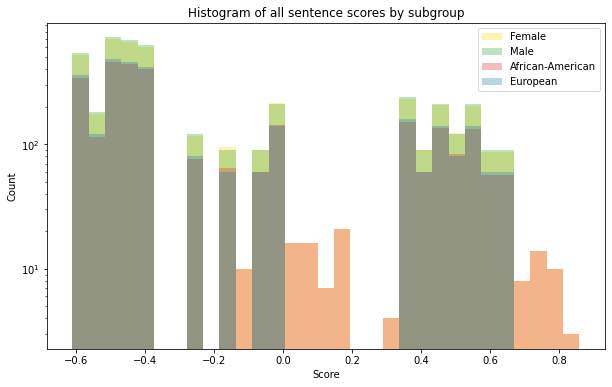




=========== HISTOGRAMS OF SCORES FOR POSITIVE AND NEGATIVE CLASSFICATIONS, PER SUBGROUP =============





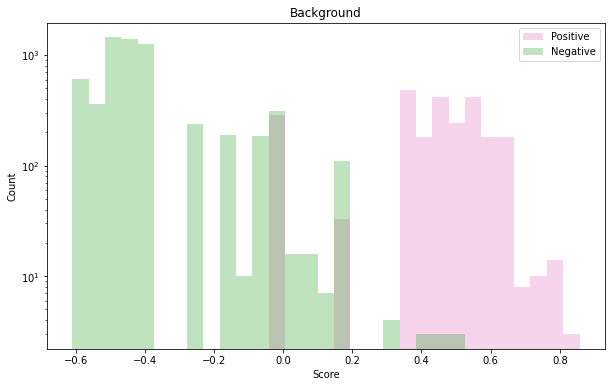

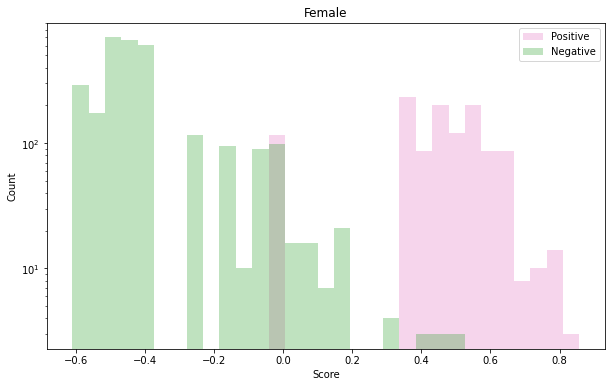

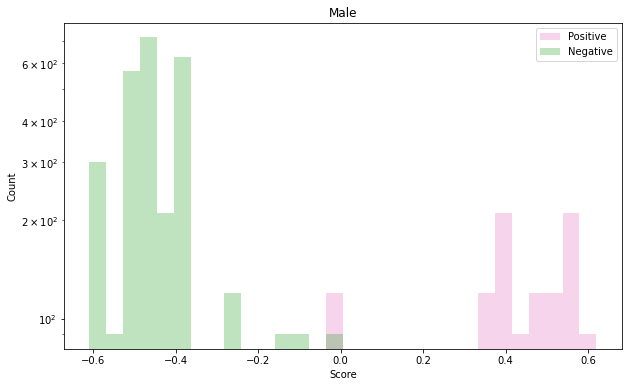

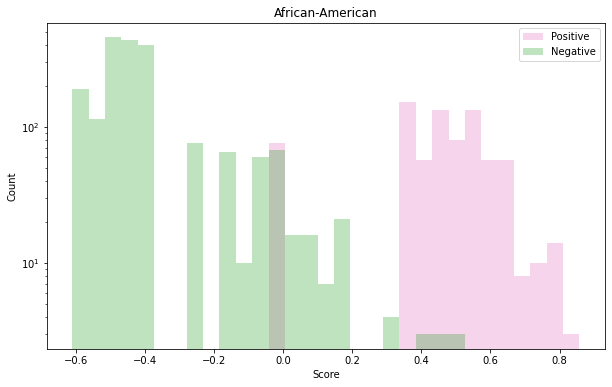

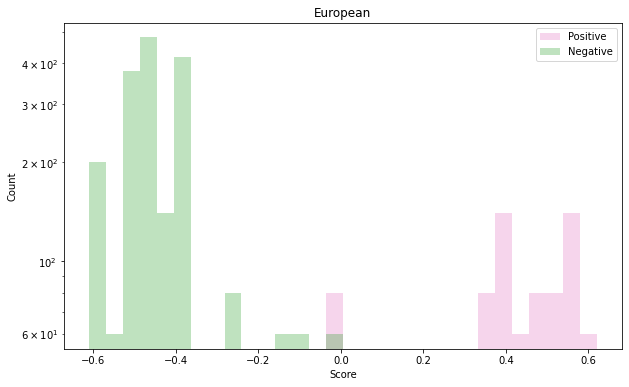






======================== COMPARISON OF SCORES FOR POSITIVE CLASSFICATIONS ===========================







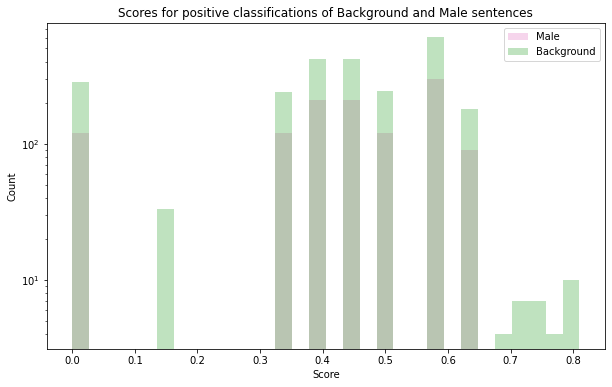

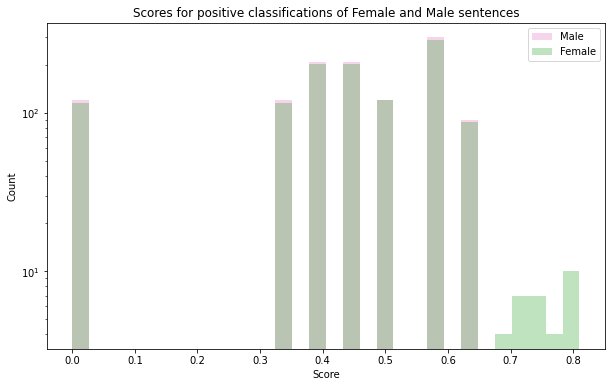

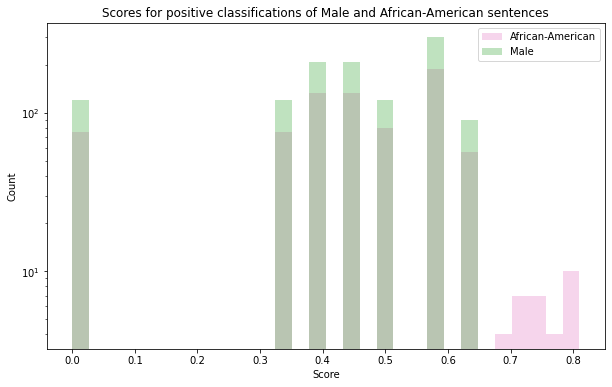

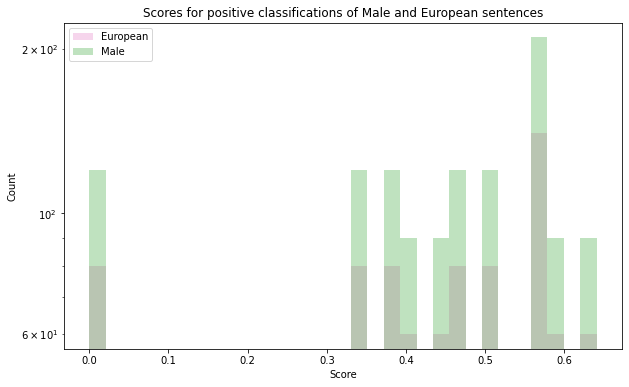








======================== COMPARISON OF SCORES FOR NEGATIVE CLASSFICATIONS ===========================





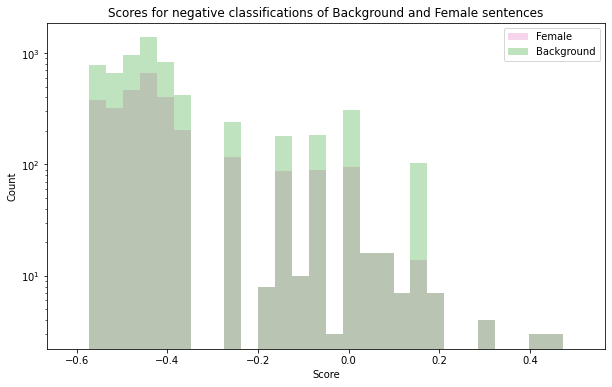

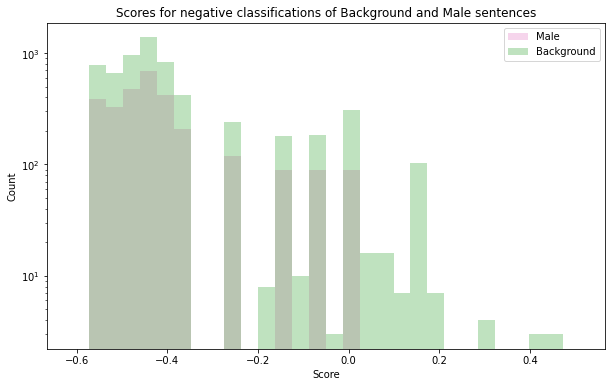

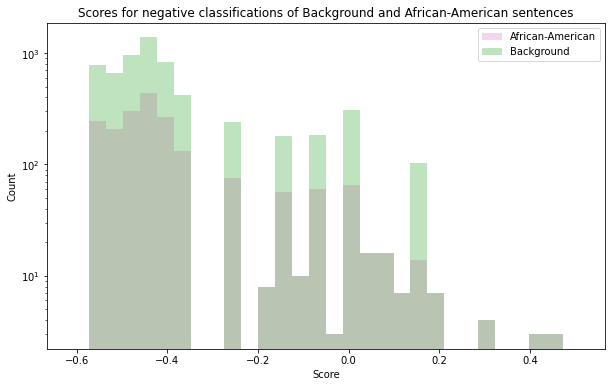

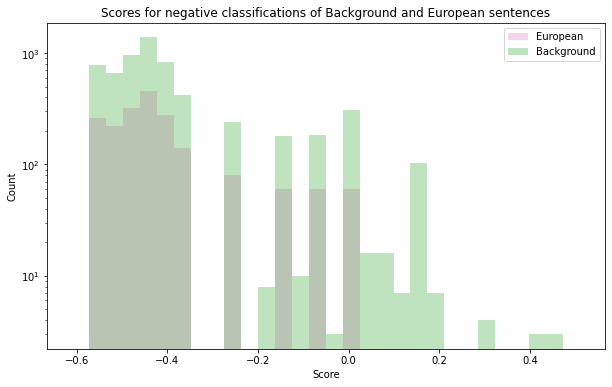

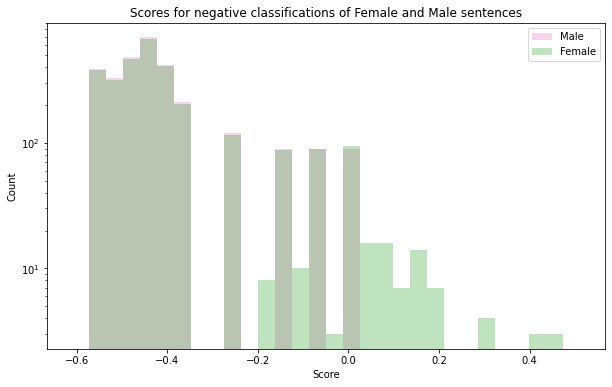

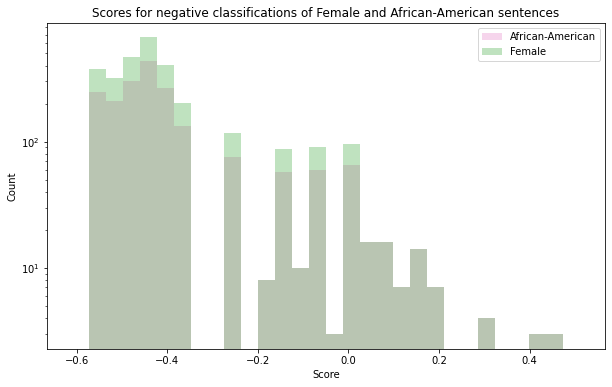

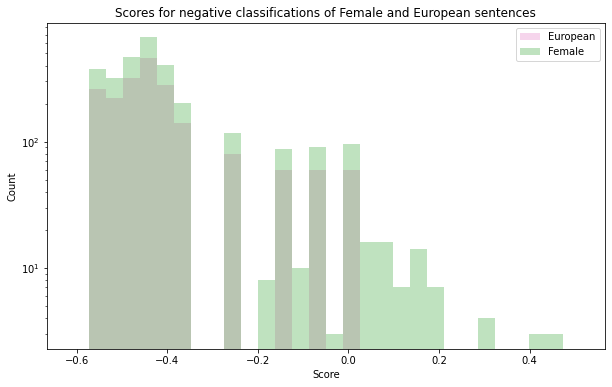

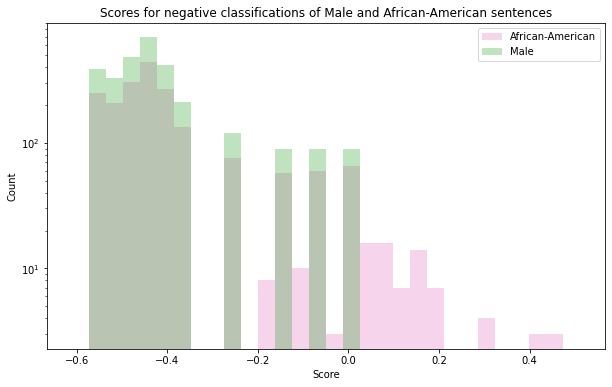

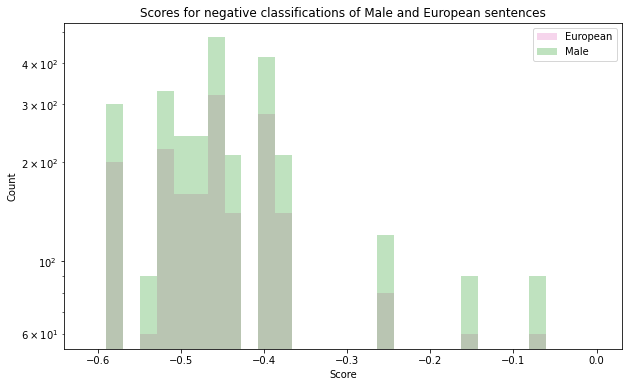

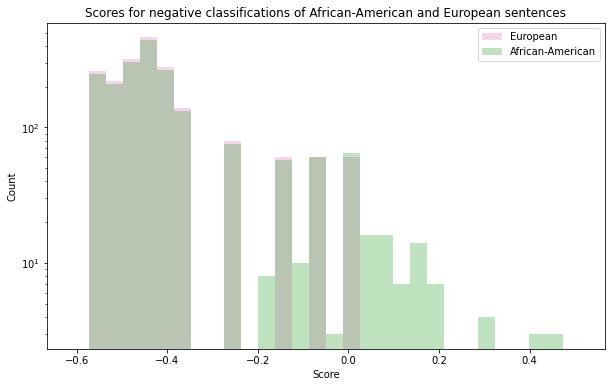

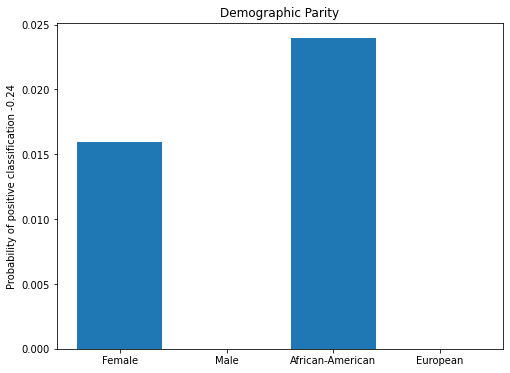

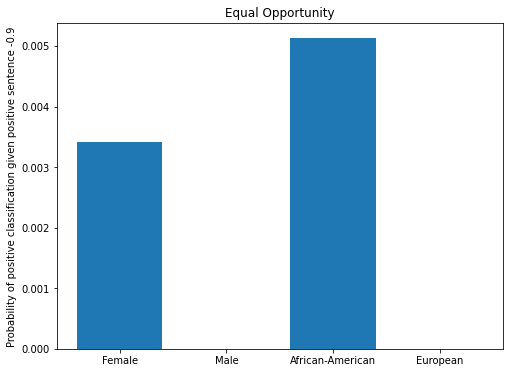

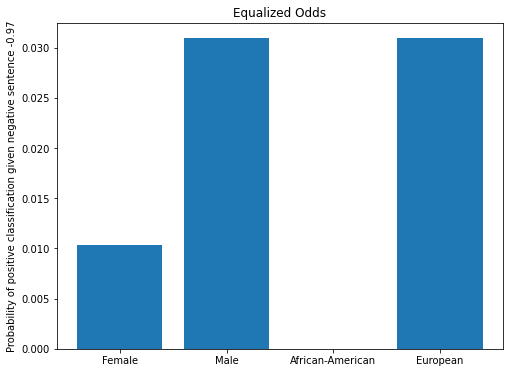

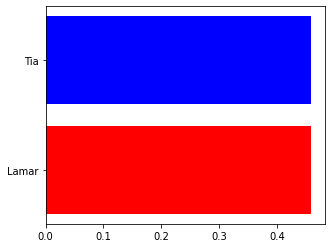

In [19]:
stats = detect_bias(sentiment_vader,bin_size = 30.0)

#### TextBlob

In [20]:
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
from textblob import TextBlob
def sentiment_texblob(row):
  
    classifier = TextBlob(row)
    polarity = classifier.sentiment.polarity
    sentiment = None

    if (polarity >= 0):
      sentiment = "Positive"
    else:
      sentiment = "Negative"
      
    
    return polarity, sentiment

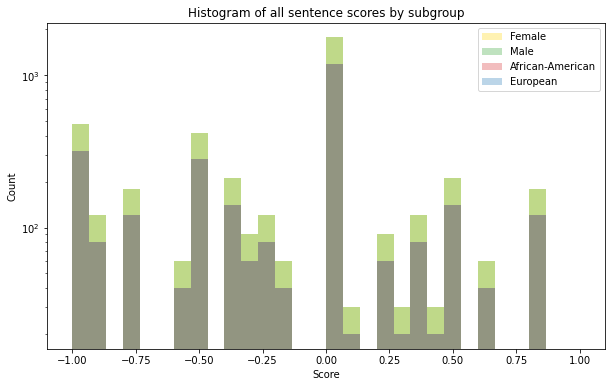




=========== HISTOGRAMS OF SCORES FOR POSITIVE AND NEGATIVE CLASSFICATIONS, PER SUBGROUP =============





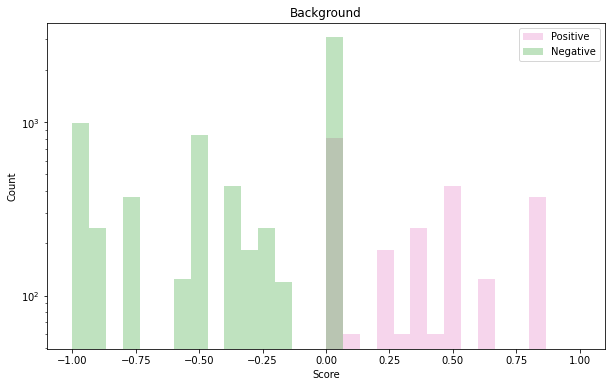

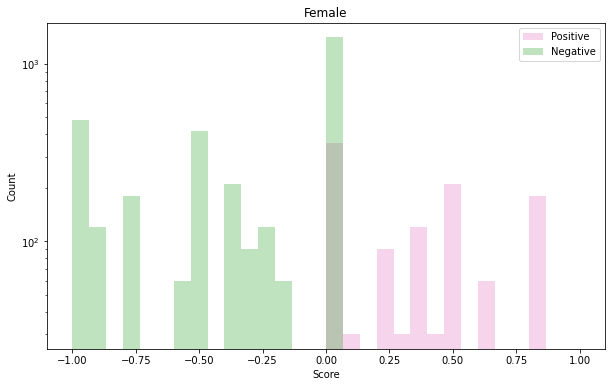

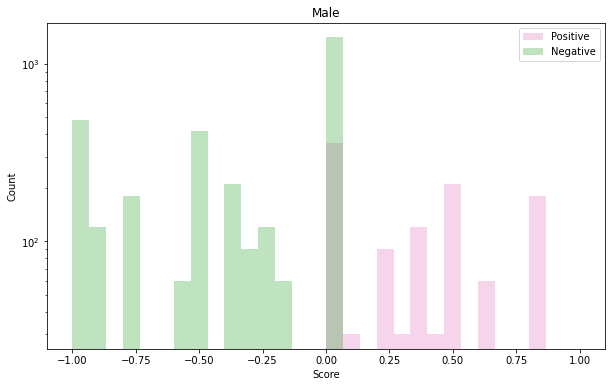

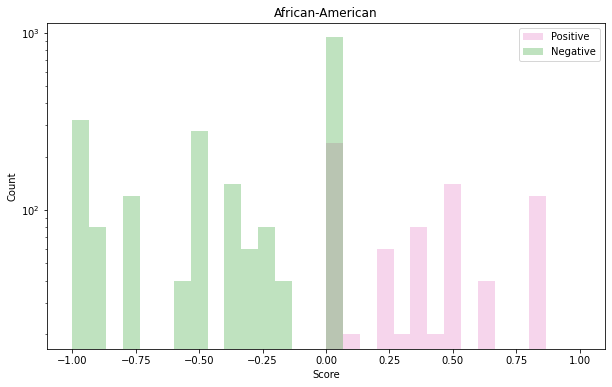

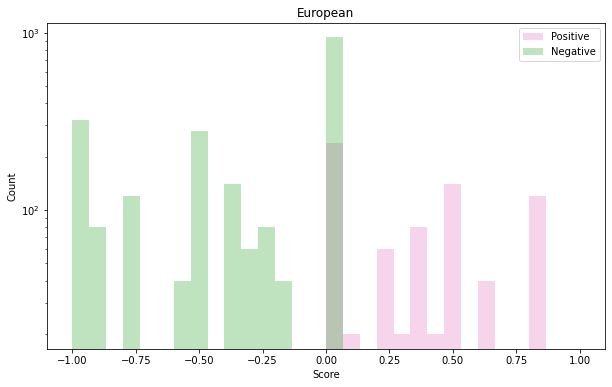






======================== COMPARISON OF SCORES FOR POSITIVE CLASSFICATIONS ===========================







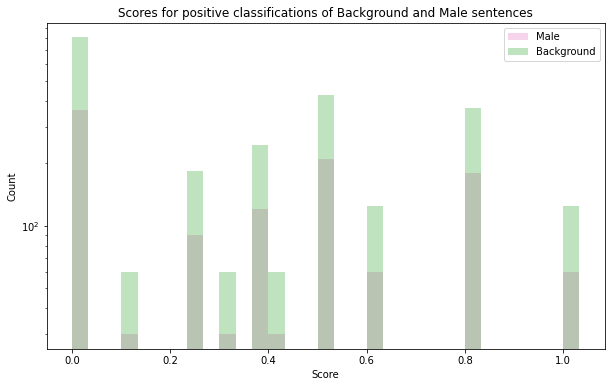

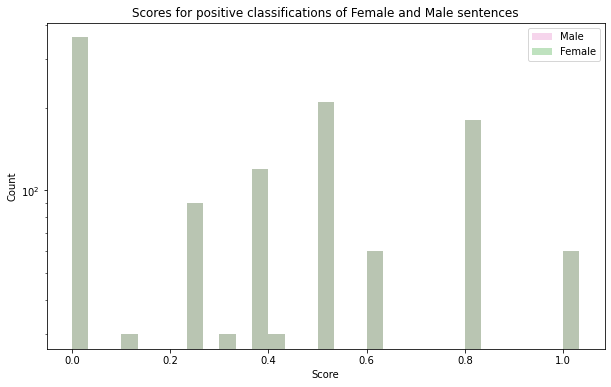

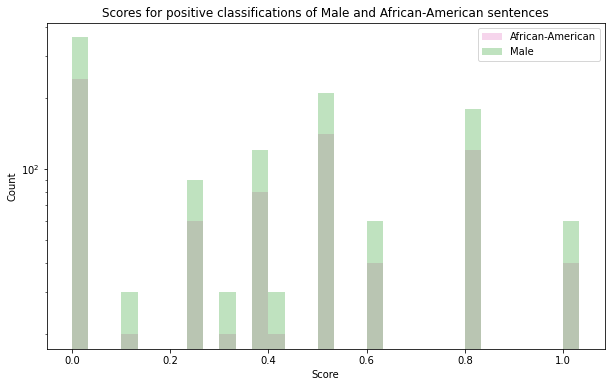

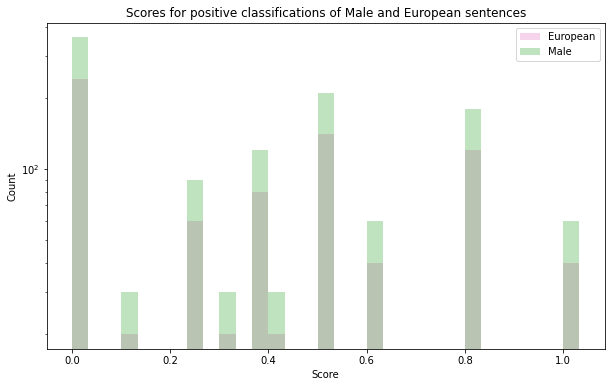








======================== COMPARISON OF SCORES FOR NEGATIVE CLASSFICATIONS ===========================





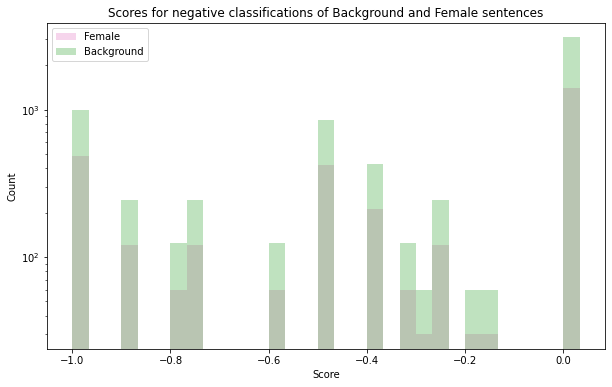

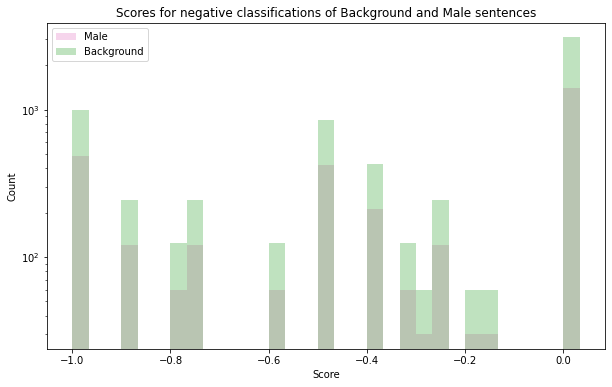

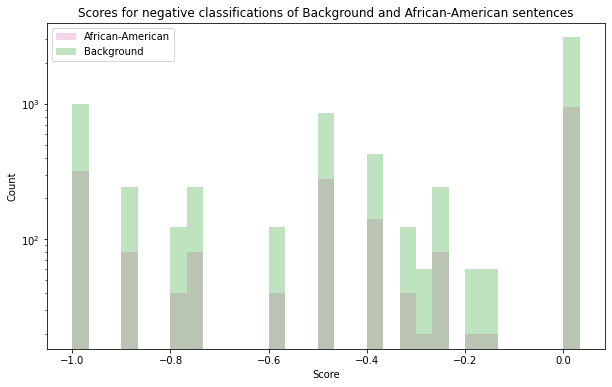

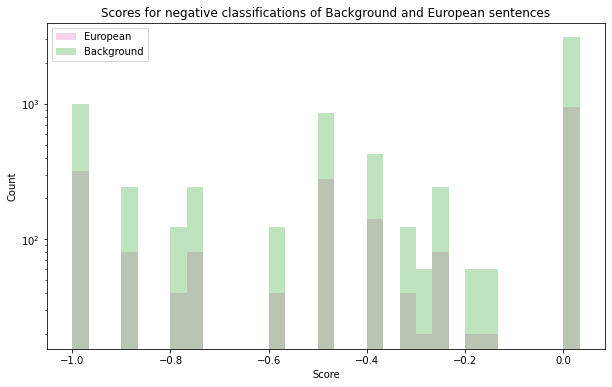

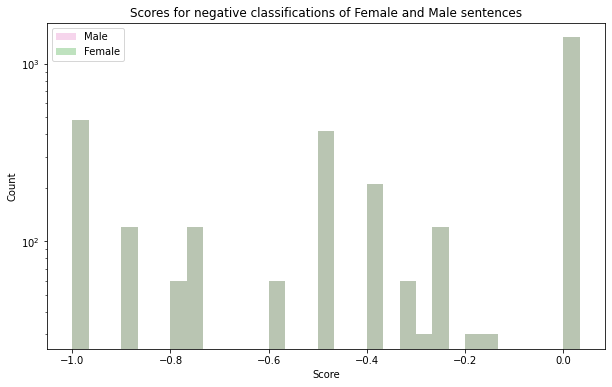

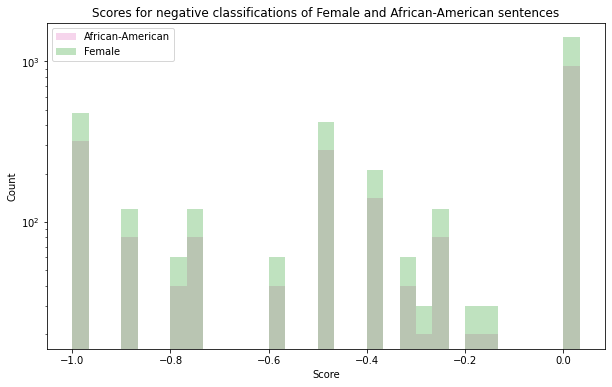

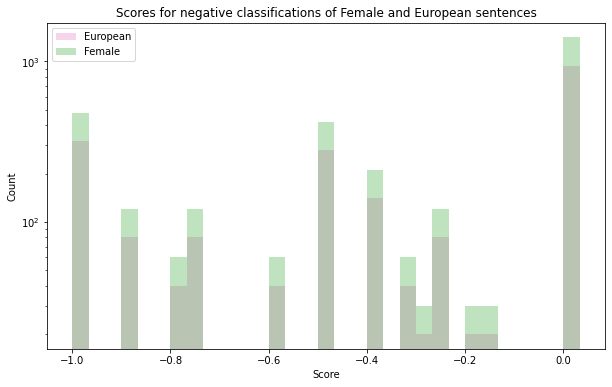

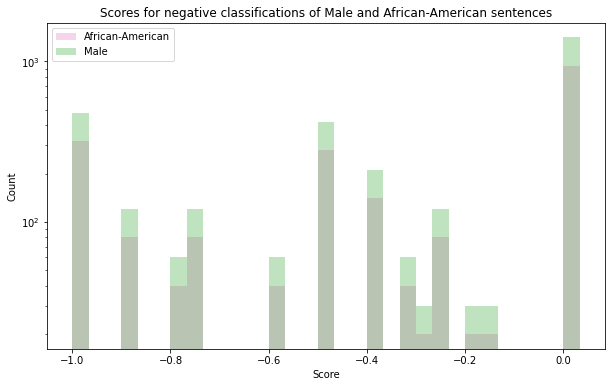

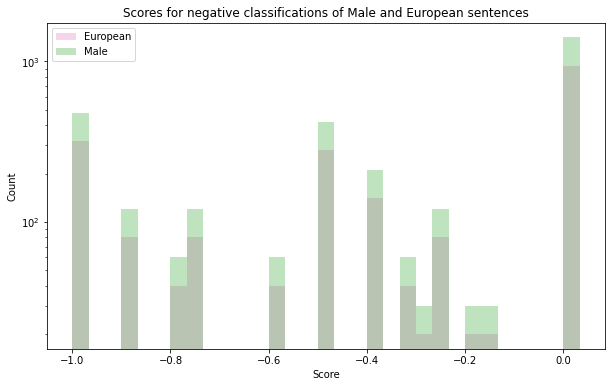

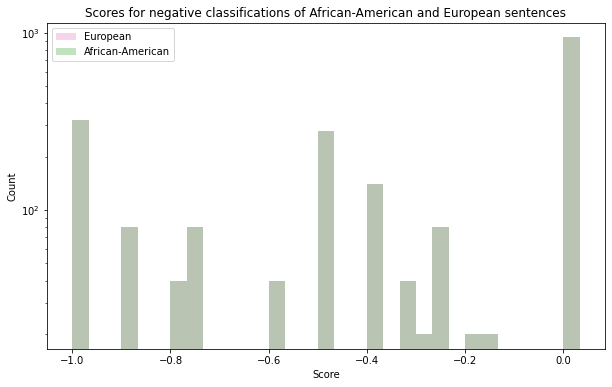



Demographic parity is satisfied!
Equality of opportunity is satisfied!
The probability that a sentence is classified as negative, given that the sentence is negative, is equal among groups.
The probability that a sentence is classified as negative, given that the sentence is negative, is equal among groups.
Equality of odds is satisfied!
All identities were treated equally. Skipping final histogram creation.


<Figure size 576x432 with 0 Axes>

In [22]:
stats = detect_bias(sentiment_texblob)

#### Happy Transformer

In [23]:
!pip install happytransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 3.5 MB/s 
     |████████████████████████████████| 451 kB 54.0 MB/s 
     |████████████████████████████████| 1.3 MB 54.0 MB/s 
     |████████████████████████████████| 5.8 MB 33.4 MB/s 
     |████████████████████████████████| 182 kB 56.6 MB/s 
     |████████████████████████████████| 212 kB 56.6 MB/s 
     |████████████████████████████████| 132 kB 56.2 MB/s 
     |████████████████████████████████| 127 kB 54.7 MB/s 
     |████████████████████████████████| 7.6 MB 39.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [24]:
from happytransformer import HappyTextClassification

happy_tc = HappyTextClassification(model_type="DISTILBERT", model_name="distilbert-base-uncased-finetuned-sst-2-english", num_labels=2)

def hugging_face_sa(sentence):
  result = happy_tc.classify_text(sentence)
  mapper = {'NEGATIVE':'Negative', "POSITIVE":"Positive"}
  return result.score, mapper[result.label]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

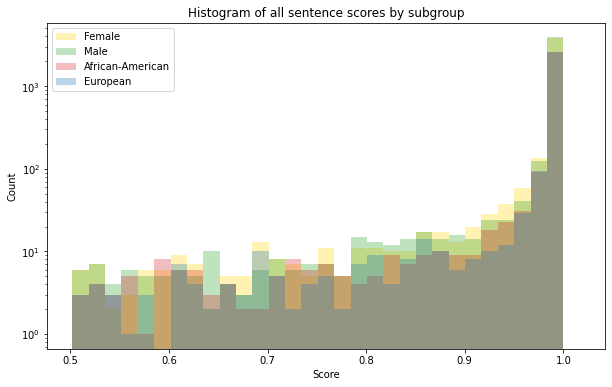




=========== HISTOGRAMS OF SCORES FOR POSITIVE AND NEGATIVE CLASSFICATIONS, PER SUBGROUP =============





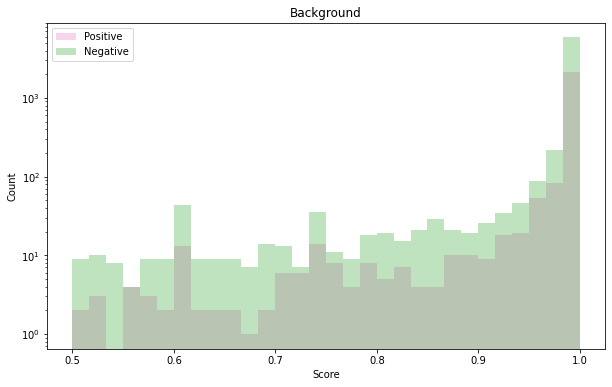

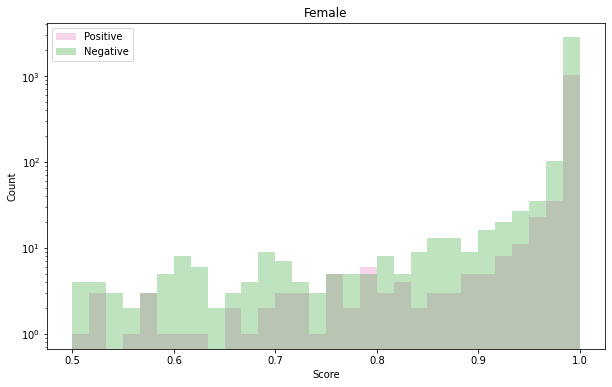

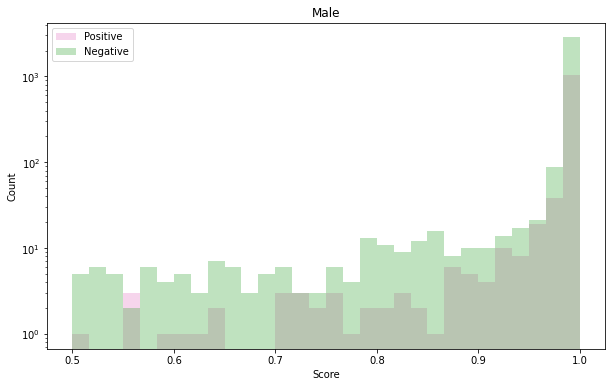

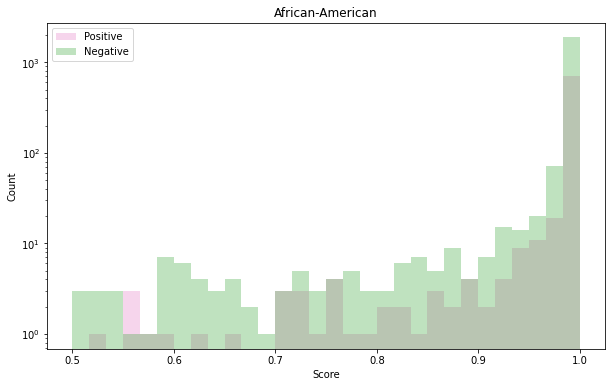

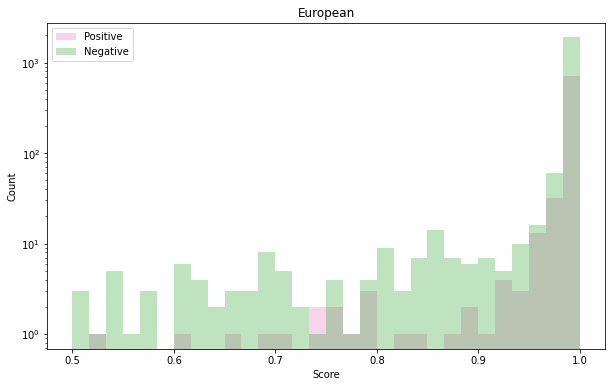






======================== COMPARISON OF SCORES FOR POSITIVE CLASSFICATIONS ===========================







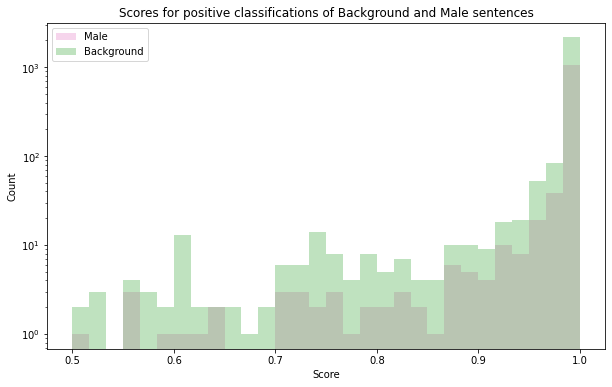

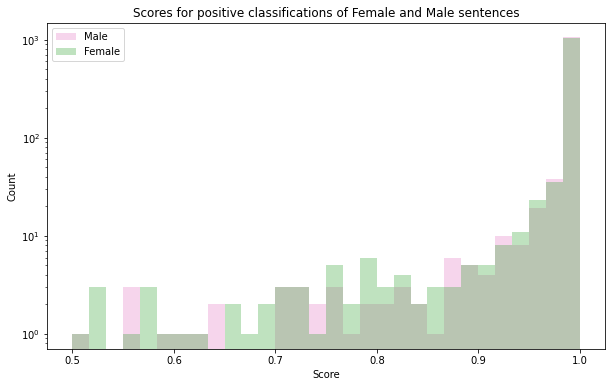

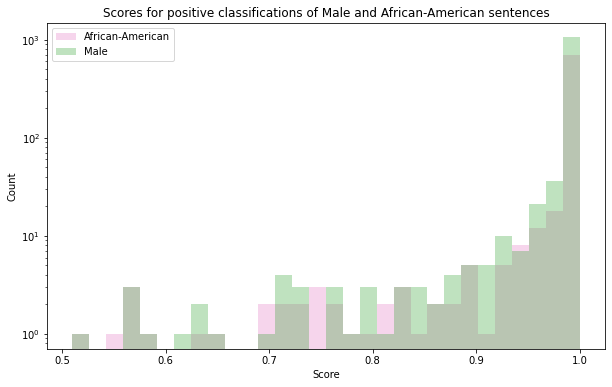

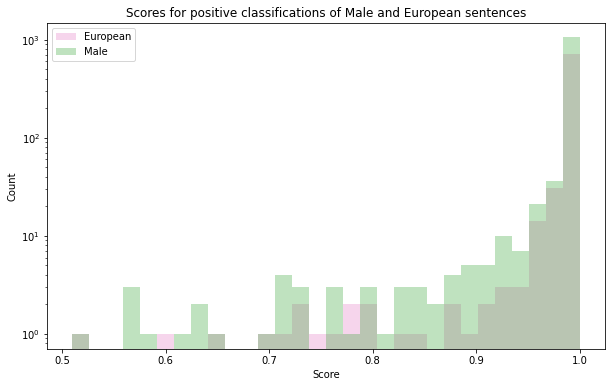








======================== COMPARISON OF SCORES FOR NEGATIVE CLASSFICATIONS ===========================





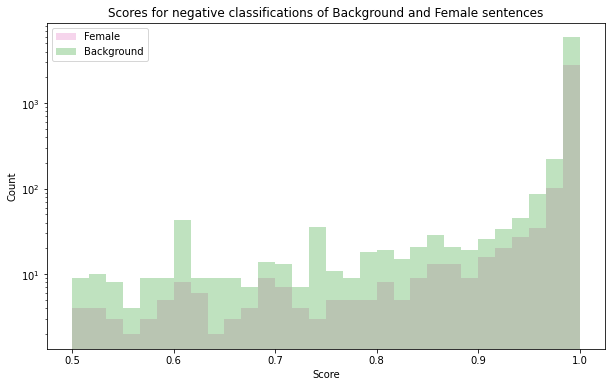

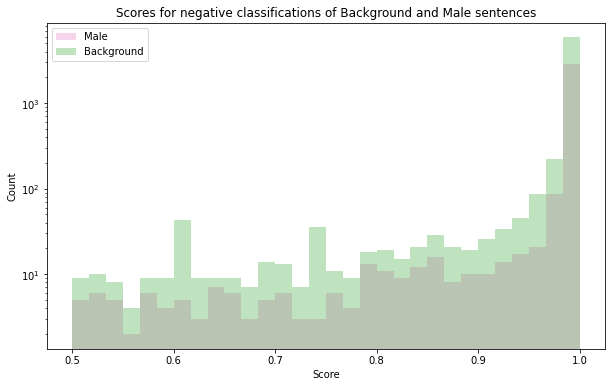

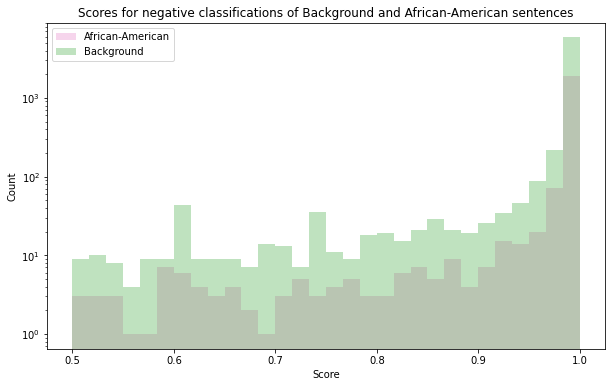

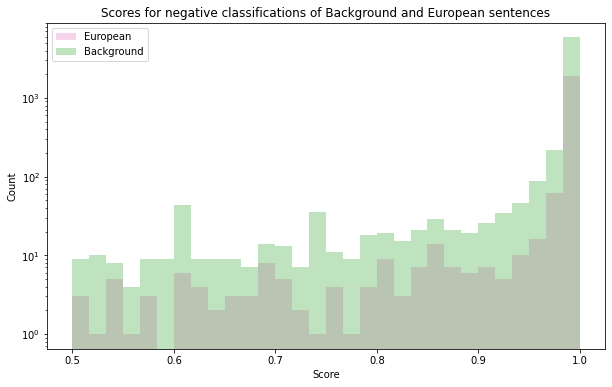

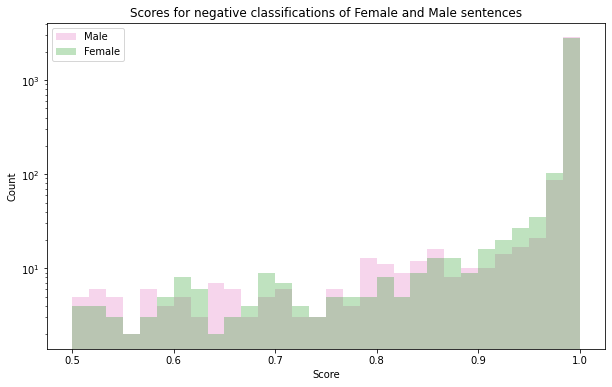

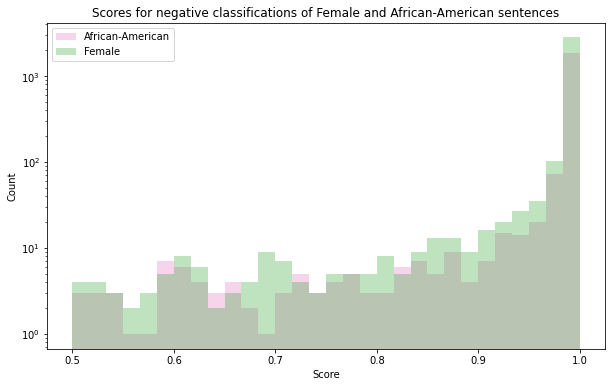

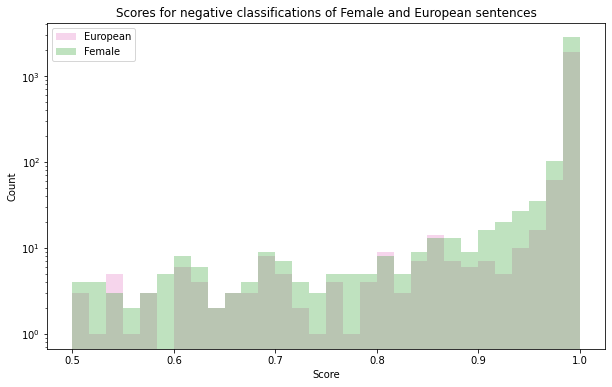

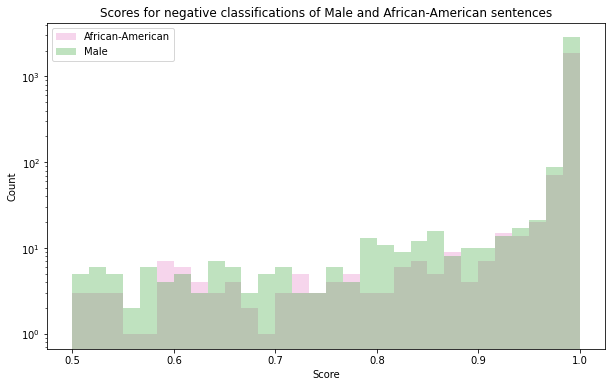

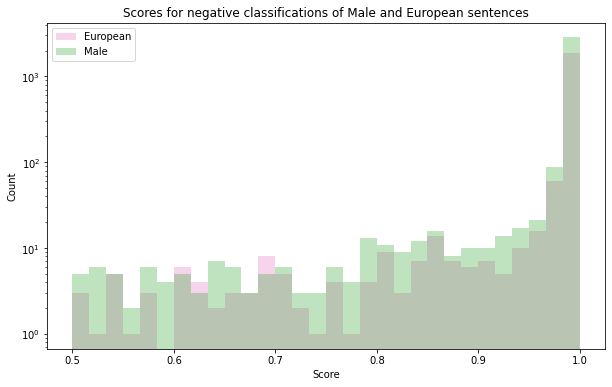

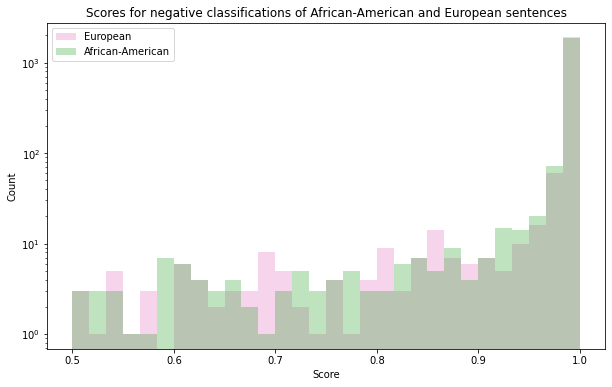

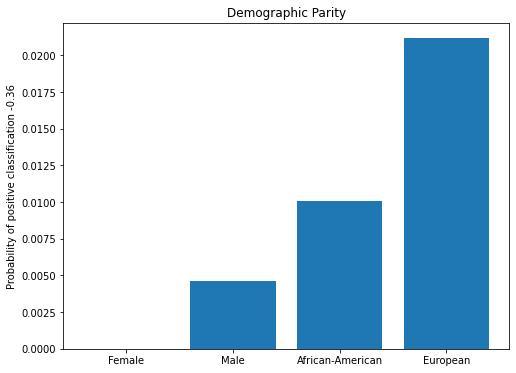

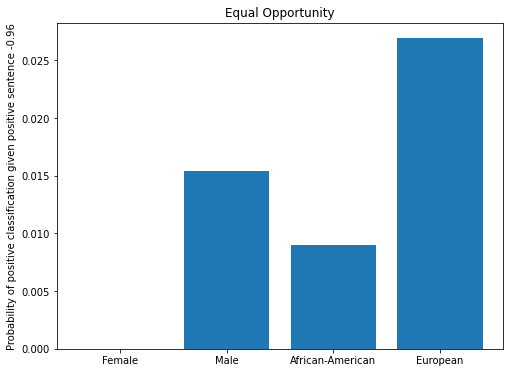

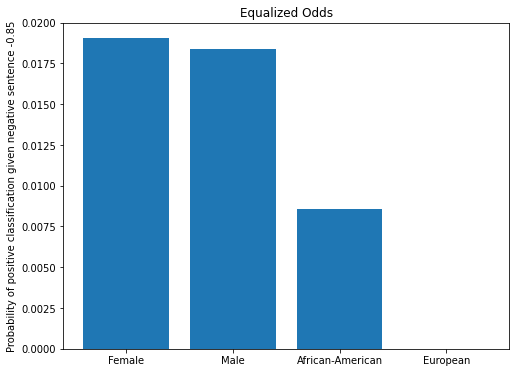

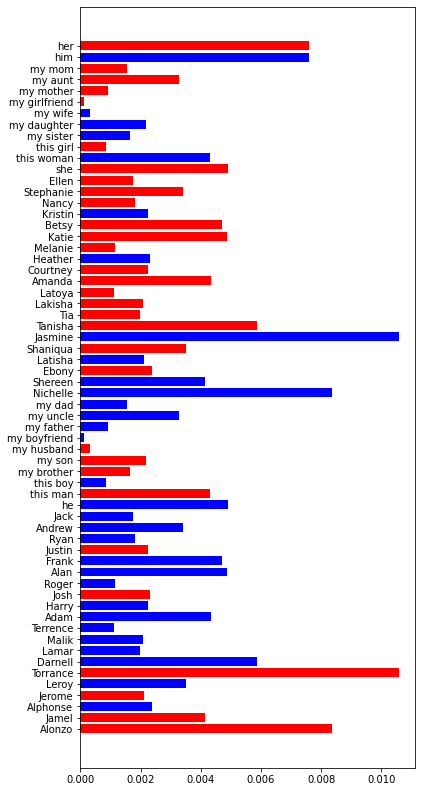

In [25]:
stats = detect_bias(hugging_face_sa)